Visualizing a few images from the CIFAR-10 dataset

100%|██████████| 170498071/170498071 [00:13<00:00, 13112035.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


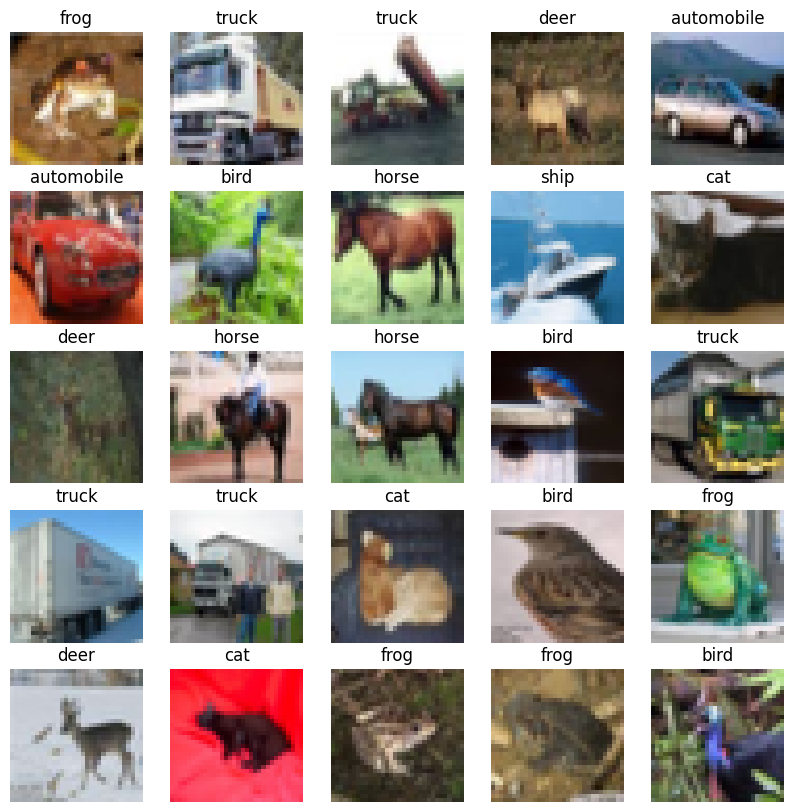

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

# Define the class names
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Load the CIFAR-10 dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor()])
cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define a function to display a grid of images from the dataset
def display_images_grid(images, titles, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(np.transpose(images[i*cols+j].numpy(), (1, 2, 0)))
            axs[i,j].set_title(class_names[titles[i*cols+j]])
            axs[i,j].axis('off')
    plt.show()

# Display a grid of 25 images from the dataset
images = []
titles = []
for i in range(25):
    image, label = cifar_dataset[i]
    images.append(image)
    titles.append(label)
display_images_grid(images, titles, 5, 5)

'DatasetFetcher' allows fetching and preparing data loaders for the CIFAR-10 dataset using PyTorch's DataLoader class. The class supports data augmentation and normalization. The data augmentation consists of random horizontal flip, random crop, and equalization of the image. The normalization is based on the mean and standard deviation of the training dataset. The code initializes the 'DatasetFetcher' object, adds data augmentation and normalization, and retrieves the training and testing data loaders. The batch_size parameter specifies the number of samples per batch, while size and padding parameters in dataAugmentation method control the size and padding of the random crop.

In [2]:
import torch
import multiprocessing
import torchvision
# import numpy as np
from torch.utils.data import DataLoader

class DatasetFetcher:
    
    def __init__(self, dataset="CIFAR10", batch_size=128):
        # Initialize the class with the specified dataset name and batch size
        print("Initializing fetching %s dataset using torchvision"%(dataset))
        self.datasetObject = torchvision.datasets.__dict__.get(dataset, None)
        if self.datasetObject == None:
            raise Exception("Dataset %s not available in torchvision."%(dataset))
        self.batch_size = batch_size
        self.train_transformers = []
        self.test_transformers = []
        self.workersAvailable = min(multiprocessing.cpu_count(), 14)

    def augmentData(self):
        # Add a transformer that randomly flips the image horizontally during training
        self.train_transformers.append(torchvision.transforms.RandomHorizontalFlip())
        # Add a transformer that randomly crops the image during training
        self.train_transformers.append(torchvision.transforms.RandomCrop(size=32, padding=3))
        # Add a transformer that equalizes the histogram of the image during both training and testing
        self.train_transformers.append(torchvision.transforms.functional.equalize)
        self.test_transformers.append(torchvision.transforms.functional.equalize)

    def __addToTensor(self):
        # Helper function to add a transformer that converts the image to a tensor during both training and testing
        self.train_transformers.append(torchvision.transforms.ToTensor())
        self.test_transformers.append(torchvision.transforms.ToTensor())
        
    def __loadTrainNormalizers(self):
        # Helper function to load the mean and standard deviation of the training dataset
        params = np.load("./trainNormalizedParameters.npz")
        return params['mean'], params['std']

    def addNormalizer(self):
        # Add a transformer that normalizes the image during both training and testing
        self.__addToTensor()
        trainingDataset = self.datasetObject(root="./data", train=True, download=True)
        trainData = trainingDataset.data/255.0
        mean = trainData.mean(axis=(0, 1, 2))
        std = trainData.std(axis=(0, 1, 2))
        np.savez("./trainNormalizedParameters", mean=mean, std=std)
        self.train_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
        self.test_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
 
        # function to get train and test loaders
    def getLoaders(self):
        # check if train transformers are empty and add 'ToTensor' transformer
        if len(self.train_transformers) == 0:
            self.__addToTensor()
            
        # create training dataset using the 'train_transformers'
        train_dataset = self.datasetObject(
            root="./data", train=True, download=True,
            transform=torchvision.transforms.Compose(self.train_transformers)
        )
        
        # create testing dataset using the 'test_transformers'
        test_dataset = self.datasetObject(
            root="./data", train=False, download=True,
            transform=torchvision.transforms.Compose(self.test_transformers)
        )
        
        # create train loader using the training dataset
        train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True,
            num_workers=self.workersAvailable
        )
        
        # create test loader using the testing dataset
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False,
            num_workers=self.workersAvailable
        )
        
        return train_loader, test_loader

    # function to get test loader
    def getTestLoader(self):
        # get mean and std dev of train dataset
        mean, std = self.__loadTrainNormalizers()
        
        # append 'ToTensor' and 'Normalize' transformers to 'test_transformers'
        self.test_transformers.append(torchvision.transforms.ToTensor())
        self.test_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
        
        # create testing dataset using the updated 'test_transformers'
        test_dataset = self.datasetObject(
            root="./data", train=False, download=True,
            transform=torchvision.transforms.Compose(self.test_transformers)
        )
        
        # create test loader using the testing dataset
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False,
            num_workers=self.workersAvailable
        )
        
        return test_loader

# main code block
if __name__ == "__main__":
    # create an instance of DatasetFetcher class with CIFAR10 dataset and batch size of 128
    df = DatasetFetcher(dataset="CIFAR10", batch_size=128)
    
    # add transformations to the dataset
    df.augmentData()
    df.addNormalizer()
    
    # get train and test loaders using the added transformations
    train_loader, test_loader = df.getLoaders()

   

Initializing fetching CIFAR10 dataset using torchvision
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified



Worked on the basic resnet model from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py \\
C - Number of channels \\
F - Filter size \\
K - Kernel size \\
P - Pool size \\

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, kernel_size, skip_kernel, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
         # Batch normalization layer after the first convolution
        self.bn1 = nn.BatchNorm2d(planes)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        # Batch normalization layer after the second convolution
        self.bn2 = nn.BatchNorm2d(planes)

         # Shortcuts are used to add the input to the output of the residual block
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
           # If the input and output dimensions are not the same, use a convolutional layer to match the dimensions
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=skip_kernel, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
      # Apply the first convolutional layer, followed by batch normalization and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Apply the second convolutional layer, followed by batch normalization
        out = self.bn2(self.conv2(out))
        # Add the shortcut connection
        out += self.shortcut(x)
         # Apply ReLU activation to the output
        out = F.relu(out)
        return out

class ResNet(nn.Module):

    def __init__(self,N:int, B:list, C:list, F:list, K:list, P:int, num_classes=10):
      # Call the superclass constructor to initialize the nn.Module
        super(ResNet, self).__init__()
        self.in_planes = C[0]
        self.block = BasicBlock
        self.N, self.B, self.C, self.F, self.K, self.P= N, B, C, F, K, P
        self.layers = []          # layers container
        self.S = [2] * N          # strides for layers
        self.S[0] = 1

        # Output Liner layer input dimension
        self.outLayerInSize = C[N-1]*(32//(P*2**(N-1)))*(32//(P*2**(N-1)))

        # Print Model Config
        print("\n\nModel Config: "
            "\n-------------------------------------"
            "\nN (# Layers)\t:",self.N,
            "\nB (# Blocks)\t:",self.B,
            "\nC (# Channels)\t:",C,
            "\nF (Conv Kernel)\t:",F,
            "\nK (Skip Kernel)\t:",K,
            "\nP (Pool Kernel)\t:",P,)

         # Create the first convolutional layer and batch normalization layer
        self.conv1 = nn.Conv2d(3, C[0], kernel_size=F[0], stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(C[0])
        # Create the remaining layers using the specified number of blocks
        for i in range(N): 
            exec("self.layer{} = self._make_layer(self.block, self.C[{}], self.B[{}], self.F[{}], self.K[{}], self.S[{}])"\
                .format(i+1,i,i,i,i,i))
            exec("self.layers.append(self.layer{})".format(i+1))
        # Create the output layer
        self.linear = nn.Linear(self.outLayerInSize, num_classes)
        # Set the path to save the model
        self.path = "./saved_model.pt"
        

    def _make_layer(self, block, planes, num_blocks, kernel_size, skip_kernel, stride):
      # Create a list of strides for each block in the layer
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        # Create each block in the layer
        for stride in strides:
           # Append the block to the list of blocks in the layer
            layers.append(block(self.in_planes, planes, kernel_size, skip_kernel, stride))
            # Update the number of input channels for the next bloc
            self.in_planes = planes
            # Return the layer as a sequential module
        return nn.Sequential(*layers)

    def forward(self, x):
        # Apply the first convolutional layer followed by batch normalization and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Apply the remaining layers in the network
        for layer in self.layers:
            out = layer(out)
        # Apply average pooling with kernel size P
        out = F.avg_pool2d(out, self.P)
        # Flatten the output tensor
        out = out.view(out.size(0), -1)
        # Apply the final linear layer to produce the output tensor
        out = self.linear(out)
        # Return the output tensor
        return out

     #Define a function to save the model to disk
    def saveToDisk(self):
      torch.save(self.state_dict(), self.path)

    #Define a function to load the model from disk
    def loadFromDisk(self):
      self.load_state_dict(torch.load(self.path))

def resnet_model():
  B=[3,3,2,3]
  C=[64,128,128,256]
  F=[3,3,3,3]
  K=[1,1,1,1]
  P=4
  N=len(B)

  return ResNet(N, B, C, F, K, P)

In [4]:
import torch
# Set random seed to ensure reproducibility
torch.manual_seed(17)

import numpy as np
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [5]:
model = resnet_model()
model = model.to(device)
# Count the number of trainable parameters in the model
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
# Print the number of trainable parameters
print("Number of trainable parameters:",trainable_parameters)



Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4
Number of trainable parameters: 4935242


To determine the model's best accuracy, we run it for 300 epochs. After that, accuracy becomes almost constant. We specify the following parameters: learning rate, weight decay, and kind of optimizer to be employed (Adam, Adagrad, and AdaDelta), with Adadelta providing the greatest accuracy. A cosine annealing scheduler was used to determine the learning rate for each parameter group.

In [6]:
# Define number of epochs
EPOCHS = 300
# Initialize global best accuracy
globalBestAccuracy = 0.0
# Create empty lists to store training and testing losses and accuracies
trainingLoss = []
testingLoss = []
trainingAccuracy = []
testingAccuracy = []

In [7]:
# Defining Loss Function, Learning Rate, Weight Decay, Optimizer
lossFunction = torch.nn.CrossEntropyLoss(reduction='sum')
learningRate = 0.01
weightDecay = 0.0001

optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)
print(model.eval())
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Number of Trainable Parameters : %s"%(trainable_parameters))
if trainable_parameters > 5*(10**6):
    raise Exception("Model parameters are out of range")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

Now we train and test the model for 300 epochs.

In [8]:
def train(model,loader, optimizer):
    model.train()
    optimizer.zero_grad()
    return model, optimizer

# Training loop
for i in tqdm(range(EPOCHS)):   # Loop over the number of epochs
    for phase in ['train', 'test']:  # Loop over the training and test phases
        if phase == "train": # Set the loader and model mode based on the phase
            loader = train_loader
            model,optimizer= train(model,loader,optimizer)
        else:
            loader = test_loader
            #test
            model.eval()
        runningLoss = 0.0  # Initialize the running loss and corrects
        runningCorrects = 0
        for images, labels in loader:  # Loop over the batches of data
            images = images.to(device)  # Move images and labels to device
            labels = labels.to(device)
            output = model(images)  # Forward pass through the model
            loss = lossFunction(output, labels)  # Compute the loss
            predicted_labels = torch.argmax(output, dim=1)  # Get the predicted labels
            runningLoss += loss.item()  # Update the running loss and corrects
            runningCorrects += torch.sum(predicted_labels == labels).float().item()
            if phase == "train":  # Backward pass and optimization for training phase
                loss.backward()
                optimizer.step()
        epochLoss = runningLoss/len(loader.dataset)  # Compute the epoch loss and accuracy
        epochAccuracy = runningCorrects/len(loader.dataset)
        if phase == "train":  # Update the scheduler and training statistics
            scheduler.step()
            trainingLoss.append(epochLoss)
            trainingAccuracy.append(epochAccuracy)
        else:  # Update the testing statistics and save the model if it is the best so far
            testingLoss.append(epochLoss)
            testingAccuracy.append(epochAccuracy)
            if epochAccuracy > globalBestAccuracy:
                globalBestAccuracy = epochAccuracy
                model.saveToDisk()
    # Print the statistics for the current epoch
    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\
          %(trainingLoss[-1], testingLoss[-1], trainingAccuracy[-1], testingAccuracy[-1]))


  0%|          | 1/300 [00:18<1:34:31, 18.97s/it]

Training Loss : 1.731184821472168, Testing Loss : 1.9217402671813966, Training Accuracy : 0.37148, Testing Accuracy : 0.3517


  1%|          | 2/300 [00:29<1:09:32, 14.00s/it]

Training Loss : 1.402977261505127, Testing Loss : 1.3283626148223877, Training Accuracy : 0.49718, Testing Accuracy : 0.527


  1%|          | 3/300 [00:39<1:01:23, 12.40s/it]

Training Loss : 1.1894069458007812, Testing Loss : 1.250297274208069, Training Accuracy : 0.57664, Testing Accuracy : 0.5667


  1%|▏         | 4/300 [00:50<58:11, 11.80s/it]  

Training Loss : 1.0435925096130372, Testing Loss : 1.0673064311981202, Training Accuracy : 0.6333, Testing Accuracy : 0.6338


  2%|▏         | 5/300 [01:01<56:22, 11.47s/it]

Training Loss : 0.9326471215820312, Testing Loss : 0.9805940351486206, Training Accuracy : 0.67518, Testing Accuracy : 0.6657


  2%|▏         | 6/300 [01:12<54:25, 11.11s/it]

Training Loss : 0.8565593923950195, Testing Loss : 0.886496744632721, Training Accuracy : 0.7001, Testing Accuracy : 0.6955


  2%|▏         | 7/300 [01:22<53:05, 10.87s/it]

Training Loss : 0.7901516492462158, Testing Loss : 0.8984624863624573, Training Accuracy : 0.72506, Testing Accuracy : 0.699


  3%|▎         | 8/300 [01:32<52:11, 10.73s/it]

Training Loss : 0.740584853515625, Testing Loss : 0.8399878952026367, Training Accuracy : 0.74294, Testing Accuracy : 0.7228


  3%|▎         | 9/300 [01:43<51:37, 10.64s/it]

Training Loss : 0.7021480533599853, Testing Loss : 0.8369942342758179, Training Accuracy : 0.75736, Testing Accuracy : 0.719


  3%|▎         | 10/300 [01:54<51:24, 10.64s/it]

Training Loss : 0.6651426783752441, Testing Loss : 0.768151064825058, Training Accuracy : 0.7717, Testing Accuracy : 0.741


  4%|▎         | 11/300 [02:04<50:48, 10.55s/it]

Training Loss : 0.6199481192016602, Testing Loss : 0.7063732694625855, Training Accuracy : 0.78616, Testing Accuracy : 0.7604


  4%|▍         | 12/300 [02:14<50:21, 10.49s/it]

Training Loss : 0.5680277931213379, Testing Loss : 0.6844936069488525, Training Accuracy : 0.8045, Testing Accuracy : 0.7709


  4%|▍         | 13/300 [02:25<50:03, 10.47s/it]

Training Loss : 0.5504513780212402, Testing Loss : 0.656376259469986, Training Accuracy : 0.8099, Testing Accuracy : 0.7788


  5%|▍         | 14/300 [02:35<49:45, 10.44s/it]

Training Loss : 0.5230900497055053, Testing Loss : 0.6257706557273864, Training Accuracy : 0.81958, Testing Accuracy : 0.7885


  5%|▌         | 15/300 [02:45<49:30, 10.42s/it]

Training Loss : 0.4981013021850586, Testing Loss : 0.6462730722904205, Training Accuracy : 0.82724, Testing Accuracy : 0.7867


  5%|▌         | 16/300 [02:56<49:27, 10.45s/it]

Training Loss : 0.4864595664215088, Testing Loss : 0.6180527647018432, Training Accuracy : 0.83012, Testing Accuracy : 0.792


  6%|▌         | 17/300 [03:06<49:20, 10.46s/it]

Training Loss : 0.4529139698028564, Testing Loss : 0.5801852366924286, Training Accuracy : 0.84282, Testing Accuracy : 0.8027


  6%|▌         | 18/300 [03:17<49:00, 10.43s/it]

Training Loss : 0.4299483203125, Testing Loss : 0.5854657860755921, Training Accuracy : 0.85082, Testing Accuracy : 0.8059


  6%|▋         | 19/300 [03:27<48:36, 10.38s/it]

Training Loss : 0.41853496185302735, Testing Loss : 0.5756806592464447, Training Accuracy : 0.85514, Testing Accuracy : 0.807


  7%|▋         | 20/300 [03:38<48:37, 10.42s/it]

Training Loss : 0.40036197425842285, Testing Loss : 0.5525728073120117, Training Accuracy : 0.8607, Testing Accuracy : 0.8168


  7%|▋         | 21/300 [03:48<48:17, 10.39s/it]

Training Loss : 0.3816496985626221, Testing Loss : 0.5536846117019654, Training Accuracy : 0.86638, Testing Accuracy : 0.8155


  7%|▋         | 22/300 [03:58<47:57, 10.35s/it]

Training Loss : 0.35463213817596434, Testing Loss : 0.5061645185470581, Training Accuracy : 0.87774, Testing Accuracy : 0.8337


  8%|▊         | 23/300 [04:09<47:52, 10.37s/it]

Training Loss : 0.35208790504455567, Testing Loss : 0.5278306823730469, Training Accuracy : 0.87746, Testing Accuracy : 0.8214


  8%|▊         | 24/300 [04:19<47:48, 10.39s/it]

Training Loss : 0.33862815547943115, Testing Loss : 0.5280848318099975, Training Accuracy : 0.88312, Testing Accuracy : 0.8346


  8%|▊         | 25/300 [04:29<47:38, 10.39s/it]

Training Loss : 0.3254013401031494, Testing Loss : 0.5552533352851867, Training Accuracy : 0.88836, Testing Accuracy : 0.8182


  9%|▊         | 26/300 [04:40<47:23, 10.38s/it]

Training Loss : 0.3210701846694946, Testing Loss : 0.5312824666976929, Training Accuracy : 0.88996, Testing Accuracy : 0.8344


  9%|▉         | 27/300 [04:50<47:15, 10.39s/it]

Training Loss : 0.30256340154647826, Testing Loss : 0.5347322523117065, Training Accuracy : 0.89504, Testing Accuracy : 0.8285


  9%|▉         | 28/300 [05:01<47:09, 10.40s/it]

Training Loss : 0.2979578883934021, Testing Loss : 0.49723754568099976, Training Accuracy : 0.89586, Testing Accuracy : 0.8387


 10%|▉         | 29/300 [05:11<47:01, 10.41s/it]

Training Loss : 0.27129117792129515, Testing Loss : 0.4954985640525818, Training Accuracy : 0.90612, Testing Accuracy : 0.8409


 10%|█         | 30/300 [05:21<46:41, 10.37s/it]

Training Loss : 0.2715217465591431, Testing Loss : 0.49848881454467775, Training Accuracy : 0.90498, Testing Accuracy : 0.8471


 10%|█         | 31/300 [05:32<46:24, 10.35s/it]

Training Loss : 0.26337940677642824, Testing Loss : 0.5019694045066834, Training Accuracy : 0.90978, Testing Accuracy : 0.8504


 11%|█         | 32/300 [05:42<46:09, 10.33s/it]

Training Loss : 0.24453795106887818, Testing Loss : 0.4983940585136414, Training Accuracy : 0.91438, Testing Accuracy : 0.8481


 11%|█         | 33/300 [05:52<45:55, 10.32s/it]

Training Loss : 0.23777976261138917, Testing Loss : 0.4932275812625885, Training Accuracy : 0.91578, Testing Accuracy : 0.8477


 11%|█▏        | 34/300 [06:03<45:46, 10.33s/it]

Training Loss : 0.2414522172164917, Testing Loss : 0.5526309628009796, Training Accuracy : 0.915, Testing Accuracy : 0.8386


 12%|█▏        | 35/300 [06:13<45:45, 10.36s/it]

Training Loss : 0.23483062519073486, Testing Loss : 0.49060773735046387, Training Accuracy : 0.91792, Testing Accuracy : 0.8545


 12%|█▏        | 36/300 [06:23<45:43, 10.39s/it]

Training Loss : 0.21928051429748535, Testing Loss : 0.4980173676490784, Training Accuracy : 0.92532, Testing Accuracy : 0.8554


 12%|█▏        | 37/300 [06:34<45:30, 10.38s/it]

Training Loss : 0.20904359302520753, Testing Loss : 0.49967118592262266, Training Accuracy : 0.92638, Testing Accuracy : 0.8516


 13%|█▎        | 38/300 [06:44<45:01, 10.31s/it]

Training Loss : 0.2084396064567566, Testing Loss : 0.4969888247489929, Training Accuracy : 0.92756, Testing Accuracy : 0.8521


 13%|█▎        | 39/300 [06:54<44:58, 10.34s/it]

Training Loss : 0.1972476926612854, Testing Loss : 0.5457663491725921, Training Accuracy : 0.93036, Testing Accuracy : 0.8507


 13%|█▎        | 40/300 [07:05<44:54, 10.36s/it]

Training Loss : 0.19481496389389039, Testing Loss : 0.5189068429946899, Training Accuracy : 0.93218, Testing Accuracy : 0.8502


 14%|█▎        | 41/300 [07:15<44:48, 10.38s/it]

Training Loss : 0.1865811665725708, Testing Loss : 0.5217310118675232, Training Accuracy : 0.93344, Testing Accuracy : 0.852


 14%|█▍        | 42/300 [07:25<44:32, 10.36s/it]

Training Loss : 0.18648192400932312, Testing Loss : 0.5245250761032104, Training Accuracy : 0.93424, Testing Accuracy : 0.8533


 14%|█▍        | 43/300 [07:36<44:34, 10.41s/it]

Training Loss : 0.17891667384147644, Testing Loss : 0.48703913202285765, Training Accuracy : 0.93642, Testing Accuracy : 0.858


 15%|█▍        | 44/300 [07:46<44:18, 10.38s/it]

Training Loss : 0.16573471445083618, Testing Loss : 0.5134642571449279, Training Accuracy : 0.9408, Testing Accuracy : 0.8597


 15%|█▌        | 45/300 [07:57<44:01, 10.36s/it]

Training Loss : 0.16169220824241637, Testing Loss : 0.5183109023094177, Training Accuracy : 0.9433, Testing Accuracy : 0.8553


 15%|█▌        | 46/300 [08:07<44:05, 10.41s/it]

Training Loss : 0.16080454716682435, Testing Loss : 0.5098760892868042, Training Accuracy : 0.943, Testing Accuracy : 0.8644


 16%|█▌        | 47/300 [08:18<43:56, 10.42s/it]

Training Loss : 0.14510075778961182, Testing Loss : 0.49371920185089113, Training Accuracy : 0.94894, Testing Accuracy : 0.8672


 16%|█▌        | 48/300 [08:28<43:44, 10.42s/it]

Training Loss : 0.13585804735183715, Testing Loss : 0.5232036454200745, Training Accuracy : 0.95248, Testing Accuracy : 0.8673


 16%|█▋        | 49/300 [08:38<43:29, 10.40s/it]

Training Loss : 0.1448541082572937, Testing Loss : 0.5075066969871521, Training Accuracy : 0.94876, Testing Accuracy : 0.8671


 17%|█▋        | 50/300 [08:49<43:14, 10.38s/it]

Training Loss : 0.1291234101343155, Testing Loss : 0.549103775882721, Training Accuracy : 0.95308, Testing Accuracy : 0.8587


 17%|█▋        | 51/300 [08:59<42:58, 10.36s/it]

Training Loss : 0.12549737315177917, Testing Loss : 0.5217211218833924, Training Accuracy : 0.95528, Testing Accuracy : 0.8678


 17%|█▋        | 52/300 [09:09<42:40, 10.32s/it]

Training Loss : 0.13131349363803863, Testing Loss : 0.5730908826828003, Training Accuracy : 0.95338, Testing Accuracy : 0.8573


 18%|█▊        | 53/300 [09:20<42:36, 10.35s/it]

Training Loss : 0.12903287335395813, Testing Loss : 0.5136102886199951, Training Accuracy : 0.95516, Testing Accuracy : 0.8668


 18%|█▊        | 54/300 [09:30<42:33, 10.38s/it]

Training Loss : 0.12180339292049408, Testing Loss : 0.5158158630371094, Training Accuracy : 0.95668, Testing Accuracy : 0.8669


 18%|█▊        | 55/300 [09:40<42:18, 10.36s/it]

Training Loss : 0.12280894282341004, Testing Loss : 0.5134987836837769, Training Accuracy : 0.95668, Testing Accuracy : 0.8674


 19%|█▊        | 56/300 [09:51<42:08, 10.36s/it]

Training Loss : 0.10926576904296875, Testing Loss : 0.5228705528259278, Training Accuracy : 0.9617, Testing Accuracy : 0.8666


 19%|█▉        | 57/300 [10:01<42:00, 10.37s/it]

Training Loss : 0.10279224033355713, Testing Loss : 0.5318633931159973, Training Accuracy : 0.96394, Testing Accuracy : 0.8662


 19%|█▉        | 58/300 [10:12<41:56, 10.40s/it]

Training Loss : 0.10629999565601349, Testing Loss : 0.5165492918968201, Training Accuracy : 0.96298, Testing Accuracy : 0.871


 20%|█▉        | 59/300 [10:22<41:45, 10.40s/it]

Training Loss : 0.10186266767501831, Testing Loss : 0.5004446593284607, Training Accuracy : 0.96438, Testing Accuracy : 0.8734


 20%|██        | 60/300 [10:32<41:28, 10.37s/it]

Training Loss : 0.09797202293395996, Testing Loss : 0.5737002530574798, Training Accuracy : 0.96614, Testing Accuracy : 0.868


 20%|██        | 61/300 [10:43<41:23, 10.39s/it]

Training Loss : 0.09428697546482086, Testing Loss : 0.5737589918136596, Training Accuracy : 0.96728, Testing Accuracy : 0.8679


 21%|██        | 62/300 [10:53<41:08, 10.37s/it]

Training Loss : 0.10714544934749604, Testing Loss : 0.5910789926528931, Training Accuracy : 0.96164, Testing Accuracy : 0.8621


 21%|██        | 63/300 [11:03<40:55, 10.36s/it]

Training Loss : 0.10194214777469635, Testing Loss : 0.5406148427963257, Training Accuracy : 0.96318, Testing Accuracy : 0.8727


 21%|██▏       | 64/300 [11:14<40:41, 10.35s/it]

Training Loss : 0.09295952353954315, Testing Loss : 0.5621832941055298, Training Accuracy : 0.9672, Testing Accuracy : 0.8684


 22%|██▏       | 65/300 [11:24<40:29, 10.34s/it]

Training Loss : 0.09405446364402771, Testing Loss : 0.5907399303436279, Training Accuracy : 0.96672, Testing Accuracy : 0.8668


 22%|██▏       | 66/300 [11:35<40:29, 10.38s/it]

Training Loss : 0.09710679161310196, Testing Loss : 0.5368260077953338, Training Accuracy : 0.96594, Testing Accuracy : 0.8753


 22%|██▏       | 67/300 [11:45<40:17, 10.37s/it]

Training Loss : 0.0829764302444458, Testing Loss : 0.5249437735557556, Training Accuracy : 0.97084, Testing Accuracy : 0.8749


 23%|██▎       | 68/300 [11:55<40:06, 10.37s/it]

Training Loss : 0.07593667515277863, Testing Loss : 0.5616655815124512, Training Accuracy : 0.9733, Testing Accuracy : 0.8772


 23%|██▎       | 69/300 [12:06<39:46, 10.33s/it]

Training Loss : 0.08209409763336181, Testing Loss : 0.5848229650497436, Training Accuracy : 0.97166, Testing Accuracy : 0.8715


 23%|██▎       | 70/300 [12:16<39:35, 10.33s/it]

Training Loss : 0.08358579625844956, Testing Loss : 0.5668247117996216, Training Accuracy : 0.9707, Testing Accuracy : 0.8704


 24%|██▎       | 71/300 [12:26<39:34, 10.37s/it]

Training Loss : 0.07504938334703445, Testing Loss : 0.5926471981048584, Training Accuracy : 0.97436, Testing Accuracy : 0.8741


 24%|██▍       | 72/300 [12:37<39:23, 10.37s/it]

Training Loss : 0.07575472272157668, Testing Loss : 0.5620466974258422, Training Accuracy : 0.9736, Testing Accuracy : 0.8729


 24%|██▍       | 73/300 [12:47<39:12, 10.37s/it]

Training Loss : 0.07272930879354476, Testing Loss : 0.561363293838501, Training Accuracy : 0.97546, Testing Accuracy : 0.8769


 25%|██▍       | 74/300 [12:57<38:59, 10.35s/it]

Training Loss : 0.06901887625932694, Testing Loss : 0.551674207019806, Training Accuracy : 0.97584, Testing Accuracy : 0.8762


 25%|██▌       | 75/300 [13:08<38:52, 10.36s/it]

Training Loss : 0.06517658446788788, Testing Loss : 0.6191736852645874, Training Accuracy : 0.97672, Testing Accuracy : 0.8746


 25%|██▌       | 76/300 [13:18<38:37, 10.35s/it]

Training Loss : 0.07758765874147415, Testing Loss : 0.5587650137901307, Training Accuracy : 0.97272, Testing Accuracy : 0.8712


 26%|██▌       | 77/300 [13:28<38:28, 10.35s/it]

Training Loss : 0.06470802055835724, Testing Loss : 0.5815331373214722, Training Accuracy : 0.977, Testing Accuracy : 0.8757


 26%|██▌       | 78/300 [13:39<38:18, 10.35s/it]

Training Loss : 0.0701621196770668, Testing Loss : 0.588932737159729, Training Accuracy : 0.97528, Testing Accuracy : 0.8712


 26%|██▋       | 79/300 [13:49<38:10, 10.37s/it]

Training Loss : 0.06377523976087571, Testing Loss : 0.5531925060272217, Training Accuracy : 0.97792, Testing Accuracy : 0.8802


 27%|██▋       | 80/300 [14:00<38:04, 10.38s/it]

Training Loss : 0.059625328097343444, Testing Loss : 0.6062267347812652, Training Accuracy : 0.97934, Testing Accuracy : 0.8776


 27%|██▋       | 81/300 [14:10<38:01, 10.42s/it]

Training Loss : 0.058281505198478696, Testing Loss : 0.5991606589794158, Training Accuracy : 0.9792, Testing Accuracy : 0.8811


 27%|██▋       | 82/300 [14:21<38:11, 10.51s/it]

Training Loss : 0.06158383823513985, Testing Loss : 0.5800582821846009, Training Accuracy : 0.97766, Testing Accuracy : 0.8796


 28%|██▊       | 83/300 [14:32<38:18, 10.59s/it]

Training Loss : 0.06269811398148536, Testing Loss : 0.5808669882774353, Training Accuracy : 0.9786, Testing Accuracy : 0.8745


 28%|██▊       | 84/300 [14:42<38:20, 10.65s/it]

Training Loss : 0.058356693387031554, Testing Loss : 0.5870437210083008, Training Accuracy : 0.97954, Testing Accuracy : 0.8799


 28%|██▊       | 85/300 [14:53<38:02, 10.62s/it]

Training Loss : 0.05581180520296097, Testing Loss : 0.5836728101730346, Training Accuracy : 0.98066, Testing Accuracy : 0.8814


 29%|██▊       | 86/300 [15:04<37:53, 10.62s/it]

Training Loss : 0.051208807389736176, Testing Loss : 0.6064701747894287, Training Accuracy : 0.9822, Testing Accuracy : 0.8824


 29%|██▉       | 87/300 [15:14<37:37, 10.60s/it]

Training Loss : 0.051617201300263406, Testing Loss : 0.5697201727867126, Training Accuracy : 0.98182, Testing Accuracy : 0.8815


 29%|██▉       | 88/300 [15:24<37:11, 10.53s/it]

Training Loss : 0.05466268424808979, Testing Loss : 0.6070834859848022, Training Accuracy : 0.98136, Testing Accuracy : 0.8815


 30%|██▉       | 89/300 [15:35<36:53, 10.49s/it]

Training Loss : 0.05624752337932587, Testing Loss : 0.5707601265430451, Training Accuracy : 0.98036, Testing Accuracy : 0.8788


 30%|███       | 90/300 [15:45<36:40, 10.48s/it]

Training Loss : 0.05124541260421276, Testing Loss : 0.5998827417373658, Training Accuracy : 0.98182, Testing Accuracy : 0.8837


 30%|███       | 91/300 [15:56<36:33, 10.50s/it]

Training Loss : 0.046564424872398376, Testing Loss : 0.5842616445541382, Training Accuracy : 0.9834, Testing Accuracy : 0.8807


 31%|███       | 92/300 [16:06<36:16, 10.46s/it]

Training Loss : 0.05191612983703613, Testing Loss : 0.5938010290145874, Training Accuracy : 0.98248, Testing Accuracy : 0.8823


 31%|███       | 93/300 [16:17<36:03, 10.45s/it]

Training Loss : 0.04811088196754455, Testing Loss : 0.5969364450454712, Training Accuracy : 0.98356, Testing Accuracy : 0.8796


 31%|███▏      | 94/300 [16:27<35:56, 10.47s/it]

Training Loss : 0.04834746978342533, Testing Loss : 0.5918654219627381, Training Accuracy : 0.9827, Testing Accuracy : 0.8846


 32%|███▏      | 95/300 [16:38<35:44, 10.46s/it]

Training Loss : 0.046347752146720884, Testing Loss : 0.5769776498794555, Training Accuracy : 0.98322, Testing Accuracy : 0.8861


 32%|███▏      | 96/300 [16:48<35:32, 10.45s/it]

Training Loss : 0.0422366358435154, Testing Loss : 0.6200230131149292, Training Accuracy : 0.98534, Testing Accuracy : 0.8836


 32%|███▏      | 97/300 [16:58<35:18, 10.43s/it]

Training Loss : 0.04291584426641464, Testing Loss : 0.6176583444595337, Training Accuracy : 0.98526, Testing Accuracy : 0.8811


 33%|███▎      | 98/300 [17:09<35:04, 10.42s/it]

Training Loss : 0.04760255040347576, Testing Loss : 0.6460581760406494, Training Accuracy : 0.98298, Testing Accuracy : 0.8778


 33%|███▎      | 99/300 [17:19<34:51, 10.41s/it]

Training Loss : 0.04495546503841877, Testing Loss : 0.5916806497573852, Training Accuracy : 0.98388, Testing Accuracy : 0.883


 33%|███▎      | 100/300 [17:30<34:40, 10.40s/it]

Training Loss : 0.040169261611700056, Testing Loss : 0.6199009479522705, Training Accuracy : 0.98634, Testing Accuracy : 0.8843


 34%|███▎      | 101/300 [17:40<34:34, 10.42s/it]

Training Loss : 0.0413916065454483, Testing Loss : 0.6298468280792237, Training Accuracy : 0.98506, Testing Accuracy : 0.879


 34%|███▍      | 102/300 [17:51<34:29, 10.45s/it]

Training Loss : 0.04161485946536064, Testing Loss : 0.6345300703048706, Training Accuracy : 0.98514, Testing Accuracy : 0.8767


 34%|███▍      | 103/300 [18:01<34:13, 10.42s/it]

Training Loss : 0.042182039625644686, Testing Loss : 0.6085434413909913, Training Accuracy : 0.98542, Testing Accuracy : 0.8827


 35%|███▍      | 104/300 [18:11<34:03, 10.42s/it]

Training Loss : 0.04169795366585255, Testing Loss : 0.6083706946849823, Training Accuracy : 0.98546, Testing Accuracy : 0.8825


 35%|███▌      | 105/300 [18:22<33:48, 10.40s/it]

Training Loss : 0.04075474478900432, Testing Loss : 0.6446399610519409, Training Accuracy : 0.9861, Testing Accuracy : 0.877


 35%|███▌      | 106/300 [18:32<33:37, 10.40s/it]

Training Loss : 0.03881153400301933, Testing Loss : 0.6442982231140136, Training Accuracy : 0.9869, Testing Accuracy : 0.8856


 36%|███▌      | 107/300 [18:43<33:27, 10.40s/it]

Training Loss : 0.03132897098571062, Testing Loss : 0.6331152451515197, Training Accuracy : 0.98922, Testing Accuracy : 0.8859


 36%|███▌      | 108/300 [18:53<33:22, 10.43s/it]

Training Loss : 0.033734128593802454, Testing Loss : 0.6082211633682251, Training Accuracy : 0.9879, Testing Accuracy : 0.8888


 36%|███▋      | 109/300 [19:04<33:19, 10.47s/it]

Training Loss : 0.035743899267613885, Testing Loss : 0.6323824192047119, Training Accuracy : 0.9874, Testing Accuracy : 0.887


 37%|███▋      | 110/300 [19:14<33:02, 10.43s/it]

Training Loss : 0.03194622057557106, Testing Loss : 0.6262343826293946, Training Accuracy : 0.98964, Testing Accuracy : 0.8879


 37%|███▋      | 111/300 [19:24<32:51, 10.43s/it]

Training Loss : 0.033032199167907235, Testing Loss : 0.6341777900695801, Training Accuracy : 0.98822, Testing Accuracy : 0.8877


 37%|███▋      | 112/300 [19:35<32:37, 10.41s/it]

Training Loss : 0.03191397438287735, Testing Loss : 0.6672139424324036, Training Accuracy : 0.98854, Testing Accuracy : 0.8812


 38%|███▊      | 113/300 [19:45<32:34, 10.45s/it]

Training Loss : 0.03612947253137827, Testing Loss : 0.6318456325531006, Training Accuracy : 0.98732, Testing Accuracy : 0.8862


 38%|███▊      | 114/300 [19:56<32:19, 10.43s/it]

Training Loss : 0.03023170733138919, Testing Loss : 0.6691424357414245, Training Accuracy : 0.98974, Testing Accuracy : 0.8826


 38%|███▊      | 115/300 [20:06<32:04, 10.40s/it]

Training Loss : 0.03219791116863489, Testing Loss : 0.6428446731567383, Training Accuracy : 0.98842, Testing Accuracy : 0.8835


 39%|███▊      | 116/300 [20:16<31:54, 10.41s/it]

Training Loss : 0.027188423992097376, Testing Loss : 0.6408897828102111, Training Accuracy : 0.99022, Testing Accuracy : 0.8903


 39%|███▉      | 117/300 [20:27<31:48, 10.43s/it]

Training Loss : 0.029350837142765523, Testing Loss : 0.6479946222305298, Training Accuracy : 0.99024, Testing Accuracy : 0.8837


 39%|███▉      | 118/300 [20:37<31:31, 10.40s/it]

Training Loss : 0.028290415932536124, Testing Loss : 0.6247288301467896, Training Accuracy : 0.9902, Testing Accuracy : 0.8872


 40%|███▉      | 119/300 [20:48<31:17, 10.37s/it]

Training Loss : 0.03363424459174275, Testing Loss : 0.6226576789855957, Training Accuracy : 0.98828, Testing Accuracy : 0.8855


 40%|████      | 120/300 [20:58<31:08, 10.38s/it]

Training Loss : 0.0315226794180274, Testing Loss : 0.6393551892757415, Training Accuracy : 0.98898, Testing Accuracy : 0.8874


 40%|████      | 121/300 [21:08<31:04, 10.42s/it]

Training Loss : 0.03081948085874319, Testing Loss : 0.5944555738449097, Training Accuracy : 0.9897, Testing Accuracy : 0.89


 41%|████      | 122/300 [21:19<30:59, 10.45s/it]

Training Loss : 0.02400173391401768, Testing Loss : 0.6333569805622101, Training Accuracy : 0.99164, Testing Accuracy : 0.8898


 41%|████      | 123/300 [21:29<30:51, 10.46s/it]

Training Loss : 0.025239864484518766, Testing Loss : 0.7034662014007569, Training Accuracy : 0.99134, Testing Accuracy : 0.8829


 41%|████▏     | 124/300 [21:40<30:44, 10.48s/it]

Training Loss : 0.026403015578836203, Testing Loss : 0.6401917915344238, Training Accuracy : 0.99106, Testing Accuracy : 0.8904


 42%|████▏     | 125/300 [21:50<30:35, 10.49s/it]

Training Loss : 0.026579573456048965, Testing Loss : 0.6556492486953736, Training Accuracy : 0.99102, Testing Accuracy : 0.8923


 42%|████▏     | 126/300 [22:01<30:14, 10.43s/it]

Training Loss : 0.029127929677590727, Testing Loss : 0.6750717594146729, Training Accuracy : 0.98984, Testing Accuracy : 0.8853


 42%|████▏     | 127/300 [22:11<30:08, 10.46s/it]

Training Loss : 0.024169586201012134, Testing Loss : 0.6473733060359955, Training Accuracy : 0.99128, Testing Accuracy : 0.8938


 43%|████▎     | 128/300 [22:22<29:55, 10.44s/it]

Training Loss : 0.02641244951367378, Testing Loss : 0.6484710243225098, Training Accuracy : 0.991, Testing Accuracy : 0.8893


 43%|████▎     | 129/300 [22:32<29:44, 10.44s/it]

Training Loss : 0.02395566353112459, Testing Loss : 0.6748895499229431, Training Accuracy : 0.99208, Testing Accuracy : 0.8903


 43%|████▎     | 130/300 [22:43<29:38, 10.46s/it]

Training Loss : 0.025378041882291435, Testing Loss : 0.6565020179748535, Training Accuracy : 0.99162, Testing Accuracy : 0.8832


 44%|████▎     | 131/300 [22:53<29:29, 10.47s/it]

Training Loss : 0.024087744207084177, Testing Loss : 0.6431752740859985, Training Accuracy : 0.9912, Testing Accuracy : 0.8929


 44%|████▍     | 132/300 [23:04<29:20, 10.48s/it]

Training Loss : 0.022668080673515795, Testing Loss : 0.6230628176689148, Training Accuracy : 0.9923, Testing Accuracy : 0.8966


 44%|████▍     | 133/300 [23:14<29:05, 10.45s/it]

Training Loss : 0.01886804870992899, Testing Loss : 0.6561237237930297, Training Accuracy : 0.99404, Testing Accuracy : 0.8899


 45%|████▍     | 134/300 [23:24<28:56, 10.46s/it]

Training Loss : 0.02468827644586563, Testing Loss : 0.6598451140880585, Training Accuracy : 0.99098, Testing Accuracy : 0.889


 45%|████▌     | 135/300 [23:35<28:42, 10.44s/it]

Training Loss : 0.023842659728229045, Testing Loss : 0.7075093958854676, Training Accuracy : 0.99172, Testing Accuracy : 0.8842


 45%|████▌     | 136/300 [23:45<28:31, 10.44s/it]

Training Loss : 0.022105593679398298, Testing Loss : 0.6503217712402344, Training Accuracy : 0.99216, Testing Accuracy : 0.891


 46%|████▌     | 137/300 [23:56<28:25, 10.46s/it]

Training Loss : 0.02071051034986973, Testing Loss : 0.6632097467422485, Training Accuracy : 0.9933, Testing Accuracy : 0.8913


 46%|████▌     | 138/300 [24:06<28:11, 10.44s/it]

Training Loss : 0.018776582372188568, Testing Loss : 0.6678718217849732, Training Accuracy : 0.9933, Testing Accuracy : 0.8876


 46%|████▋     | 139/300 [24:17<27:58, 10.43s/it]

Training Loss : 0.019643433971107006, Testing Loss : 0.6461846969604492, Training Accuracy : 0.9932, Testing Accuracy : 0.8919


 47%|████▋     | 140/300 [24:27<27:41, 10.39s/it]

Training Loss : 0.018477960076853633, Testing Loss : 0.6695363952636719, Training Accuracy : 0.99322, Testing Accuracy : 0.8935


 47%|████▋     | 141/300 [24:37<27:28, 10.37s/it]

Training Loss : 0.02194660400480032, Testing Loss : 0.6662255405426025, Training Accuracy : 0.9922, Testing Accuracy : 0.8901


 47%|████▋     | 142/300 [24:48<27:26, 10.42s/it]

Training Loss : 0.021189836846143006, Testing Loss : 0.6749822233200073, Training Accuracy : 0.9928, Testing Accuracy : 0.8879


 48%|████▊     | 143/300 [24:58<27:21, 10.45s/it]

Training Loss : 0.021962069702968, Testing Loss : 0.61002454662323, Training Accuracy : 0.99222, Testing Accuracy : 0.8936


 48%|████▊     | 144/300 [25:09<27:09, 10.44s/it]

Training Loss : 0.019402578127235174, Testing Loss : 0.6489682574272155, Training Accuracy : 0.99316, Testing Accuracy : 0.8941


 48%|████▊     | 145/300 [25:19<26:58, 10.44s/it]

Training Loss : 0.01646280749168247, Testing Loss : 0.6583709177017212, Training Accuracy : 0.99472, Testing Accuracy : 0.8913


 49%|████▊     | 146/300 [25:30<26:50, 10.46s/it]

Training Loss : 0.021269666741266846, Testing Loss : 0.6621163192749023, Training Accuracy : 0.9925, Testing Accuracy : 0.8879


 49%|████▉     | 147/300 [25:40<26:35, 10.43s/it]

Training Loss : 0.017003012566268443, Testing Loss : 0.6525633466720581, Training Accuracy : 0.99412, Testing Accuracy : 0.8905


 49%|████▉     | 148/300 [25:51<26:29, 10.46s/it]

Training Loss : 0.015090056786239148, Testing Loss : 0.7162548945426941, Training Accuracy : 0.99466, Testing Accuracy : 0.8909


 50%|████▉     | 149/300 [26:01<26:20, 10.47s/it]

Training Loss : 0.016661462967842818, Testing Loss : 0.7059964164733886, Training Accuracy : 0.99448, Testing Accuracy : 0.8913


 50%|█████     | 150/300 [26:11<26:05, 10.44s/it]

Training Loss : 0.0185228324521333, Testing Loss : 0.6864847979545593, Training Accuracy : 0.9936, Testing Accuracy : 0.8886


 50%|█████     | 151/300 [26:22<25:56, 10.45s/it]

Training Loss : 0.016333302756510674, Testing Loss : 0.7325856315612793, Training Accuracy : 0.99446, Testing Accuracy : 0.8908


 51%|█████     | 152/300 [26:32<25:45, 10.45s/it]

Training Loss : 0.01721449827119708, Testing Loss : 0.7452931400299072, Training Accuracy : 0.99424, Testing Accuracy : 0.8889


 51%|█████     | 153/300 [26:43<25:41, 10.48s/it]

Training Loss : 0.015902758842259647, Testing Loss : 0.6780761262893676, Training Accuracy : 0.99486, Testing Accuracy : 0.8935


 51%|█████▏    | 154/300 [26:54<25:38, 10.54s/it]

Training Loss : 0.014966739386618137, Testing Loss : 0.706437265586853, Training Accuracy : 0.99476, Testing Accuracy : 0.896


 52%|█████▏    | 155/300 [27:04<25:25, 10.52s/it]

Training Loss : 0.01480559960503131, Testing Loss : 0.6963479217529297, Training Accuracy : 0.9949, Testing Accuracy : 0.8944


 52%|█████▏    | 156/300 [27:14<25:10, 10.49s/it]

Training Loss : 0.015837723179589955, Testing Loss : 0.7148353758811951, Training Accuracy : 0.99464, Testing Accuracy : 0.8934


 52%|█████▏    | 157/300 [27:25<25:01, 10.50s/it]

Training Loss : 0.02028726284056902, Testing Loss : 0.7091718431472779, Training Accuracy : 0.99326, Testing Accuracy : 0.8901


 53%|█████▎    | 158/300 [27:35<24:49, 10.49s/it]

Training Loss : 0.01794278444670141, Testing Loss : 0.6628019630432129, Training Accuracy : 0.99334, Testing Accuracy : 0.8954


 53%|█████▎    | 159/300 [27:46<24:38, 10.49s/it]

Training Loss : 0.014050450015366077, Testing Loss : 0.6502816778182984, Training Accuracy : 0.99582, Testing Accuracy : 0.8966


 53%|█████▎    | 160/300 [27:56<24:31, 10.51s/it]

Training Loss : 0.013984018439315259, Testing Loss : 0.7286216110229492, Training Accuracy : 0.99522, Testing Accuracy : 0.8888


 54%|█████▎    | 161/300 [28:07<24:17, 10.49s/it]

Training Loss : 0.014352175219953061, Testing Loss : 0.7166106507301331, Training Accuracy : 0.99508, Testing Accuracy : 0.8932


 54%|█████▍    | 162/300 [28:17<24:06, 10.48s/it]

Training Loss : 0.01409444807831198, Testing Loss : 0.7119249559402466, Training Accuracy : 0.9956, Testing Accuracy : 0.8922


 54%|█████▍    | 163/300 [28:28<23:57, 10.49s/it]

Training Loss : 0.01403758612640202, Testing Loss : 0.6842473858833313, Training Accuracy : 0.9953, Testing Accuracy : 0.8936


 55%|█████▍    | 164/300 [28:38<23:50, 10.52s/it]

Training Loss : 0.010288803505375982, Testing Loss : 0.7107822212219238, Training Accuracy : 0.9965, Testing Accuracy : 0.8972


 55%|█████▌    | 165/300 [28:49<23:37, 10.50s/it]

Training Loss : 0.011536160829029977, Testing Loss : 0.7028239267349243, Training Accuracy : 0.99592, Testing Accuracy : 0.8932


 55%|█████▌    | 166/300 [28:59<23:25, 10.49s/it]

Training Loss : 0.013691595698408783, Testing Loss : 0.7176337125778198, Training Accuracy : 0.99554, Testing Accuracy : 0.8933


 56%|█████▌    | 167/300 [29:10<23:13, 10.48s/it]

Training Loss : 0.013048983778483235, Testing Loss : 0.7099657899856567, Training Accuracy : 0.99548, Testing Accuracy : 0.8943


 56%|█████▌    | 168/300 [29:20<23:04, 10.49s/it]

Training Loss : 0.014945953489802778, Testing Loss : 0.7250342861175537, Training Accuracy : 0.99488, Testing Accuracy : 0.8926


 56%|█████▋    | 169/300 [29:31<22:49, 10.46s/it]

Training Loss : 0.014488297522328794, Testing Loss : 0.6783577978134155, Training Accuracy : 0.99488, Testing Accuracy : 0.8962


 57%|█████▋    | 170/300 [29:41<22:45, 10.50s/it]

Training Loss : 0.01050705420838669, Testing Loss : 0.6878891660690307, Training Accuracy : 0.99638, Testing Accuracy : 0.8978


 57%|█████▋    | 171/300 [29:52<22:34, 10.50s/it]

Training Loss : 0.011094949893401936, Testing Loss : 0.6872031911849975, Training Accuracy : 0.99624, Testing Accuracy : 0.8976


 57%|█████▋    | 172/300 [30:02<22:23, 10.49s/it]

Training Loss : 0.011025611308850347, Testing Loss : 0.7061493273735047, Training Accuracy : 0.99604, Testing Accuracy : 0.896


 58%|█████▊    | 173/300 [30:13<22:11, 10.48s/it]

Training Loss : 0.01274046373553574, Testing Loss : 0.723798994064331, Training Accuracy : 0.99572, Testing Accuracy : 0.8925


 58%|█████▊    | 174/300 [30:23<22:02, 10.50s/it]

Training Loss : 0.014284010387398302, Testing Loss : 0.6749360840797425, Training Accuracy : 0.99508, Testing Accuracy : 0.8977


 58%|█████▊    | 175/300 [30:34<21:56, 10.53s/it]

Training Loss : 0.00944862982302904, Testing Loss : 0.6824807130813598, Training Accuracy : 0.99662, Testing Accuracy : 0.8969


 59%|█████▊    | 176/300 [30:45<22:06, 10.70s/it]

Training Loss : 0.009334770282749087, Testing Loss : 0.6840043476104737, Training Accuracy : 0.99692, Testing Accuracy : 0.8977


 59%|█████▉    | 177/300 [30:56<22:08, 10.80s/it]

Training Loss : 0.007821107319444418, Testing Loss : 0.6771911214828491, Training Accuracy : 0.99732, Testing Accuracy : 0.8994


 59%|█████▉    | 178/300 [31:07<21:58, 10.81s/it]

Training Loss : 0.008498831417802721, Testing Loss : 0.6964697110176087, Training Accuracy : 0.9968, Testing Accuracy : 0.9002


 60%|█████▉    | 179/300 [31:17<21:35, 10.70s/it]

Training Loss : 0.008520640503587201, Testing Loss : 0.6874805501937866, Training Accuracy : 0.99744, Testing Accuracy : 0.8976


 60%|██████    | 180/300 [31:28<21:14, 10.62s/it]

Training Loss : 0.008823558379048482, Testing Loss : 0.7116576475143432, Training Accuracy : 0.99712, Testing Accuracy : 0.8965


 60%|██████    | 181/300 [31:38<20:59, 10.58s/it]

Training Loss : 0.008739774790219963, Testing Loss : 0.7008436111450196, Training Accuracy : 0.99726, Testing Accuracy : 0.8973


 61%|██████    | 182/300 [31:49<20:41, 10.52s/it]

Training Loss : 0.008949843867374584, Testing Loss : 0.7481891616821289, Training Accuracy : 0.997, Testing Accuracy : 0.8928


 61%|██████    | 183/300 [31:59<20:25, 10.48s/it]

Training Loss : 0.008583472074698657, Testing Loss : 0.7245828006744385, Training Accuracy : 0.9972, Testing Accuracy : 0.8955


 61%|██████▏   | 184/300 [32:09<20:11, 10.44s/it]

Training Loss : 0.009701541740372776, Testing Loss : 0.7078874572753906, Training Accuracy : 0.99692, Testing Accuracy : 0.8977


 62%|██████▏   | 185/300 [32:20<20:04, 10.48s/it]

Training Loss : 0.007983000849094242, Testing Loss : 0.7127523939132691, Training Accuracy : 0.99732, Testing Accuracy : 0.899


 62%|██████▏   | 186/300 [32:30<19:51, 10.46s/it]

Training Loss : 0.008376659963540733, Testing Loss : 0.7403715829849243, Training Accuracy : 0.99694, Testing Accuracy : 0.8983


 62%|██████▏   | 187/300 [32:41<19:41, 10.45s/it]

Training Loss : 0.008441220860956236, Testing Loss : 0.7094040697097779, Training Accuracy : 0.99718, Testing Accuracy : 0.8991


 63%|██████▎   | 188/300 [32:51<19:33, 10.48s/it]

Training Loss : 0.009144987482633442, Testing Loss : 0.7550481993675232, Training Accuracy : 0.99672, Testing Accuracy : 0.8959


 63%|██████▎   | 189/300 [33:02<19:21, 10.46s/it]

Training Loss : 0.005972945688082837, Testing Loss : 0.7009574201583862, Training Accuracy : 0.99802, Testing Accuracy : 0.8995


 63%|██████▎   | 190/300 [33:12<19:09, 10.45s/it]

Training Loss : 0.007662324522444979, Testing Loss : 0.7483167778015136, Training Accuracy : 0.99726, Testing Accuracy : 0.898


 64%|██████▎   | 191/300 [33:23<18:59, 10.46s/it]

Training Loss : 0.008414946183254942, Testing Loss : 0.7386156575679779, Training Accuracy : 0.9969, Testing Accuracy : 0.8975


 64%|██████▍   | 192/300 [33:33<18:50, 10.47s/it]

Training Loss : 0.009088199711926282, Testing Loss : 0.7806668685913086, Training Accuracy : 0.9968, Testing Accuracy : 0.8918


 64%|██████▍   | 193/300 [33:44<18:37, 10.44s/it]

Training Loss : 0.007173991793319583, Testing Loss : 0.712504899597168, Training Accuracy : 0.99762, Testing Accuracy : 0.8988


 65%|██████▍   | 194/300 [33:54<18:25, 10.43s/it]

Training Loss : 0.007222946495260112, Testing Loss : 0.771957607460022, Training Accuracy : 0.99766, Testing Accuracy : 0.8951


 65%|██████▌   | 195/300 [34:04<18:16, 10.44s/it]

Training Loss : 0.0069715760451927785, Testing Loss : 0.7068057176589966, Training Accuracy : 0.99756, Testing Accuracy : 0.8999


 65%|██████▌   | 196/300 [34:15<18:06, 10.45s/it]

Training Loss : 0.0070854977492243055, Testing Loss : 0.7536514347076416, Training Accuracy : 0.9973, Testing Accuracy : 0.8958


 66%|██████▌   | 197/300 [34:25<17:56, 10.45s/it]

Training Loss : 0.008403818583562971, Testing Loss : 0.698454207611084, Training Accuracy : 0.99728, Testing Accuracy : 0.8976


 66%|██████▌   | 198/300 [34:36<17:55, 10.55s/it]

Training Loss : 0.006586986245224253, Testing Loss : 0.7202439706802368, Training Accuracy : 0.99762, Testing Accuracy : 0.8972


 66%|██████▋   | 199/300 [34:47<17:43, 10.53s/it]

Training Loss : 0.005618779321527109, Testing Loss : 0.7280033311843872, Training Accuracy : 0.99778, Testing Accuracy : 0.9


 67%|██████▋   | 200/300 [34:57<17:26, 10.47s/it]

Training Loss : 0.005753280147486366, Testing Loss : 0.7404161363601685, Training Accuracy : 0.99778, Testing Accuracy : 0.897


 67%|██████▋   | 201/300 [35:07<17:16, 10.47s/it]

Training Loss : 0.005599931331574917, Testing Loss : 0.7263345582962036, Training Accuracy : 0.99806, Testing Accuracy : 0.9001


 67%|██████▋   | 202/300 [35:18<17:10, 10.51s/it]

Training Loss : 0.005433235477190465, Testing Loss : 0.7578312427520751, Training Accuracy : 0.99822, Testing Accuracy : 0.8999


 68%|██████▊   | 203/300 [35:28<16:54, 10.46s/it]

Training Loss : 0.006880474288440309, Testing Loss : 0.7479999195098876, Training Accuracy : 0.9977, Testing Accuracy : 0.8979


 68%|██████▊   | 204/300 [35:39<16:44, 10.46s/it]

Training Loss : 0.007691140227513387, Testing Loss : 0.7515658105850219, Training Accuracy : 0.99738, Testing Accuracy : 0.898


 68%|██████▊   | 205/300 [35:49<16:33, 10.46s/it]

Training Loss : 0.00723351500459481, Testing Loss : 0.7480239313125611, Training Accuracy : 0.9977, Testing Accuracy : 0.9002


 69%|██████▊   | 206/300 [36:00<16:22, 10.45s/it]

Training Loss : 0.0057831022831099105, Testing Loss : 0.7262891431808471, Training Accuracy : 0.998, Testing Accuracy : 0.8992


 69%|██████▉   | 207/300 [36:10<16:18, 10.52s/it]

Training Loss : 0.005552289974233135, Testing Loss : 0.7433200458526611, Training Accuracy : 0.99824, Testing Accuracy : 0.8983


 69%|██████▉   | 208/300 [36:21<16:02, 10.46s/it]

Training Loss : 0.005123960905838758, Testing Loss : 0.7558187799453735, Training Accuracy : 0.99844, Testing Accuracy : 0.8977


 70%|██████▉   | 209/300 [36:31<15:55, 10.50s/it]

Training Loss : 0.0034027690947207156, Testing Loss : 0.7454883123397827, Training Accuracy : 0.99888, Testing Accuracy : 0.9008


 70%|███████   | 210/300 [36:42<15:46, 10.51s/it]

Training Loss : 0.0046293130385666155, Testing Loss : 0.768459653377533, Training Accuracy : 0.99864, Testing Accuracy : 0.9045


 70%|███████   | 211/300 [36:52<15:34, 10.50s/it]

Training Loss : 0.004310023787743412, Testing Loss : 0.761603935623169, Training Accuracy : 0.99866, Testing Accuracy : 0.901


 71%|███████   | 212/300 [37:03<15:22, 10.49s/it]

Training Loss : 0.004222954799572472, Testing Loss : 0.7470574237823486, Training Accuracy : 0.9988, Testing Accuracy : 0.9027


 71%|███████   | 213/300 [37:13<15:14, 10.51s/it]

Training Loss : 0.0036360186839103697, Testing Loss : 0.7398069038391113, Training Accuracy : 0.9988, Testing Accuracy : 0.9025


 71%|███████▏  | 214/300 [37:24<15:03, 10.51s/it]

Training Loss : 0.0026279062555893324, Testing Loss : 0.7178611227035523, Training Accuracy : 0.99942, Testing Accuracy : 0.906


 72%|███████▏  | 215/300 [37:34<14:52, 10.50s/it]

Training Loss : 0.0036571006971993485, Testing Loss : 0.7630565901756287, Training Accuracy : 0.9987, Testing Accuracy : 0.9008


 72%|███████▏  | 216/300 [37:45<14:40, 10.49s/it]

Training Loss : 0.0037087059017829596, Testing Loss : 0.7330849651336669, Training Accuracy : 0.99866, Testing Accuracy : 0.9041


 72%|███████▏  | 217/300 [37:55<14:28, 10.47s/it]

Training Loss : 0.003625506297519896, Testing Loss : 0.7682545424461364, Training Accuracy : 0.9989, Testing Accuracy : 0.9035


 73%|███████▎  | 218/300 [38:06<14:22, 10.52s/it]

Training Loss : 0.0037971955108758995, Testing Loss : 0.7581719624519349, Training Accuracy : 0.99878, Testing Accuracy : 0.8985


 73%|███████▎  | 219/300 [38:16<14:14, 10.54s/it]

Training Loss : 0.0027978678105364087, Testing Loss : 0.7484678131103516, Training Accuracy : 0.99912, Testing Accuracy : 0.9061


 73%|███████▎  | 220/300 [38:27<14:01, 10.51s/it]

Training Loss : 0.002666933742641704, Testing Loss : 0.7889001485824585, Training Accuracy : 0.99916, Testing Accuracy : 0.8995


 74%|███████▎  | 221/300 [38:37<13:47, 10.48s/it]

Training Loss : 0.0038771467468608173, Testing Loss : 0.770070680809021, Training Accuracy : 0.99868, Testing Accuracy : 0.9001


 74%|███████▍  | 222/300 [38:48<13:36, 10.47s/it]

Training Loss : 0.004359844910912215, Testing Loss : 0.7975371538162231, Training Accuracy : 0.9985, Testing Accuracy : 0.9013


 74%|███████▍  | 223/300 [38:58<13:25, 10.46s/it]

Training Loss : 0.0034442427604342812, Testing Loss : 0.7749681871414185, Training Accuracy : 0.99878, Testing Accuracy : 0.901


 75%|███████▍  | 224/300 [39:09<13:14, 10.46s/it]

Training Loss : 0.0025359326662984676, Testing Loss : 0.7601239307403564, Training Accuracy : 0.99906, Testing Accuracy : 0.9042


 75%|███████▌  | 225/300 [39:19<13:04, 10.45s/it]

Training Loss : 0.0016976145359664224, Testing Loss : 0.7629831758499146, Training Accuracy : 0.99952, Testing Accuracy : 0.9028


 75%|███████▌  | 226/300 [39:30<12:55, 10.47s/it]

Training Loss : 0.0024600856378744354, Testing Loss : 0.7796437311172485, Training Accuracy : 0.99922, Testing Accuracy : 0.9026


 76%|███████▌  | 227/300 [39:40<12:43, 10.46s/it]

Training Loss : 0.0021225318857689855, Testing Loss : 0.7819973448753357, Training Accuracy : 0.99928, Testing Accuracy : 0.9024


 76%|███████▌  | 228/300 [39:50<12:31, 10.44s/it]

Training Loss : 0.0023663192685233663, Testing Loss : 0.8121710865974426, Training Accuracy : 0.99918, Testing Accuracy : 0.9042


 76%|███████▋  | 229/300 [40:01<12:21, 10.44s/it]

Training Loss : 0.003358221126446733, Testing Loss : 0.802265616607666, Training Accuracy : 0.99904, Testing Accuracy : 0.899


 77%|███████▋  | 230/300 [40:11<12:10, 10.43s/it]

Training Loss : 0.002065690143945394, Testing Loss : 0.814914457321167, Training Accuracy : 0.99936, Testing Accuracy : 0.902


 77%|███████▋  | 231/300 [40:22<11:58, 10.42s/it]

Training Loss : 0.0018283269565051888, Testing Loss : 0.7915250001907349, Training Accuracy : 0.99938, Testing Accuracy : 0.9022


 77%|███████▋  | 232/300 [40:32<11:47, 10.41s/it]

Training Loss : 0.0022385269929323113, Testing Loss : 0.8093018548965454, Training Accuracy : 0.99922, Testing Accuracy : 0.9018


 78%|███████▊  | 233/300 [40:43<11:40, 10.45s/it]

Training Loss : 0.0024722258615179453, Testing Loss : 0.7910920709609985, Training Accuracy : 0.9991, Testing Accuracy : 0.9036


 78%|███████▊  | 234/300 [40:53<11:30, 10.46s/it]

Training Loss : 0.003052512801287812, Testing Loss : 0.8195008718490601, Training Accuracy : 0.99898, Testing Accuracy : 0.9009


 78%|███████▊  | 235/300 [41:04<11:22, 10.50s/it]

Training Loss : 0.0022781359481066467, Testing Loss : 0.7612790863037109, Training Accuracy : 0.99926, Testing Accuracy : 0.9072


 79%|███████▊  | 236/300 [41:14<11:11, 10.49s/it]

Training Loss : 0.0018475678010558476, Testing Loss : 0.8108268957138062, Training Accuracy : 0.99942, Testing Accuracy : 0.9019


 79%|███████▉  | 237/300 [41:25<11:02, 10.52s/it]

Training Loss : 0.002228530160911032, Testing Loss : 0.7686758641242981, Training Accuracy : 0.99922, Testing Accuracy : 0.9074


 79%|███████▉  | 238/300 [41:35<10:49, 10.48s/it]

Training Loss : 0.0012917027330381096, Testing Loss : 0.789506178188324, Training Accuracy : 0.99958, Testing Accuracy : 0.9047


 80%|███████▉  | 239/300 [41:45<10:38, 10.46s/it]

Training Loss : 0.0014747536258323817, Testing Loss : 0.8084680340766907, Training Accuracy : 0.99944, Testing Accuracy : 0.9038


 80%|████████  | 240/300 [41:56<10:29, 10.50s/it]

Training Loss : 0.002217803749241866, Testing Loss : 0.8092377368927002, Training Accuracy : 0.99912, Testing Accuracy : 0.9015


 80%|████████  | 241/300 [42:07<10:19, 10.49s/it]

Training Loss : 0.0023538798259437315, Testing Loss : 0.8147804020881653, Training Accuracy : 0.99928, Testing Accuracy : 0.9037


 81%|████████  | 242/300 [42:17<10:08, 10.50s/it]

Training Loss : 0.0021130390862911007, Testing Loss : 0.8149066324234009, Training Accuracy : 0.99938, Testing Accuracy : 0.9034


 81%|████████  | 243/300 [42:27<09:56, 10.47s/it]

Training Loss : 0.0017594183241232532, Testing Loss : 0.8132188632965088, Training Accuracy : 0.9994, Testing Accuracy : 0.9051


 81%|████████▏ | 244/300 [42:38<09:47, 10.48s/it]

Training Loss : 0.0025764505441638174, Testing Loss : 0.8049641941070557, Training Accuracy : 0.99918, Testing Accuracy : 0.9039


 82%|████████▏ | 245/300 [42:48<09:35, 10.46s/it]

Training Loss : 0.0017815382003277772, Testing Loss : 0.7953935464859009, Training Accuracy : 0.99936, Testing Accuracy : 0.9045


 82%|████████▏ | 246/300 [42:59<09:23, 10.44s/it]

Training Loss : 0.0013761591662219143, Testing Loss : 0.8085474094390869, Training Accuracy : 0.9996, Testing Accuracy : 0.904


 82%|████████▏ | 247/300 [43:09<09:13, 10.44s/it]

Training Loss : 0.0015501971135436906, Testing Loss : 0.8189038949012757, Training Accuracy : 0.9995, Testing Accuracy : 0.905


 83%|████████▎ | 248/300 [43:20<09:03, 10.46s/it]

Training Loss : 0.0017100587207020727, Testing Loss : 0.8222597499847412, Training Accuracy : 0.9995, Testing Accuracy : 0.902


 83%|████████▎ | 249/300 [43:30<08:54, 10.48s/it]

Training Loss : 0.001372396212265594, Testing Loss : 0.7979781923294067, Training Accuracy : 0.9997, Testing Accuracy : 0.9052


 83%|████████▎ | 250/300 [43:41<08:44, 10.50s/it]

Training Loss : 0.0013552918776788283, Testing Loss : 0.819809818649292, Training Accuracy : 0.99958, Testing Accuracy : 0.9047


 84%|████████▎ | 251/300 [43:51<08:34, 10.50s/it]

Training Loss : 0.0008999323338683462, Testing Loss : 0.80753740940094, Training Accuracy : 0.99976, Testing Accuracy : 0.9045


 84%|████████▍ | 252/300 [44:02<08:23, 10.48s/it]

Training Loss : 0.0009362949114432559, Testing Loss : 0.8024626341819763, Training Accuracy : 0.9997, Testing Accuracy : 0.9057


 84%|████████▍ | 253/300 [44:12<08:10, 10.45s/it]

Training Loss : 0.0008827644017896091, Testing Loss : 0.8034523532867431, Training Accuracy : 0.99964, Testing Accuracy : 0.9053


 85%|████████▍ | 254/300 [44:23<08:01, 10.47s/it]

Training Loss : 0.0006570577365343342, Testing Loss : 0.8038023231506347, Training Accuracy : 0.99984, Testing Accuracy : 0.9066


 85%|████████▌ | 255/300 [44:33<07:51, 10.47s/it]

Training Loss : 0.0006090828393241099, Testing Loss : 0.795098318862915, Training Accuracy : 0.9999, Testing Accuracy : 0.91


 85%|████████▌ | 256/300 [44:44<07:41, 10.49s/it]

Training Loss : 0.0008094801971006382, Testing Loss : 0.8318134550094605, Training Accuracy : 0.99976, Testing Accuracy : 0.9065


 86%|████████▌ | 257/300 [44:54<07:29, 10.45s/it]

Training Loss : 0.0012385659267252777, Testing Loss : 0.8505069860458374, Training Accuracy : 0.99958, Testing Accuracy : 0.906


 86%|████████▌ | 258/300 [45:04<07:18, 10.45s/it]

Training Loss : 0.0015416189808060516, Testing Loss : 0.8458556524276734, Training Accuracy : 0.99944, Testing Accuracy : 0.9055


 86%|████████▋ | 259/300 [45:15<07:09, 10.46s/it]

Training Loss : 0.0014170038967579602, Testing Loss : 0.8544954992294311, Training Accuracy : 0.99954, Testing Accuracy : 0.9054


 87%|████████▋ | 260/300 [45:25<06:57, 10.45s/it]

Training Loss : 0.00083268669412093, Testing Loss : 0.8321086563110351, Training Accuracy : 0.99976, Testing Accuracy : 0.9077


 87%|████████▋ | 261/300 [45:36<06:49, 10.49s/it]

Training Loss : 0.0006317685802151391, Testing Loss : 0.841521210193634, Training Accuracy : 0.9998, Testing Accuracy : 0.9053


 87%|████████▋ | 262/300 [45:46<06:37, 10.47s/it]

Training Loss : 0.0007594980030533043, Testing Loss : 0.8293653143882751, Training Accuracy : 0.99984, Testing Accuracy : 0.9096


 88%|████████▊ | 263/300 [45:57<06:27, 10.47s/it]

Training Loss : 0.000587292029128439, Testing Loss : 0.8640127416610718, Training Accuracy : 0.99984, Testing Accuracy : 0.9078


 88%|████████▊ | 264/300 [46:07<06:16, 10.46s/it]

Training Loss : 0.0007574282465318902, Testing Loss : 0.8553020271301269, Training Accuracy : 0.9998, Testing Accuracy : 0.9063


 88%|████████▊ | 265/300 [46:18<06:06, 10.49s/it]

Training Loss : 0.0007750483917987731, Testing Loss : 0.8712206169128418, Training Accuracy : 0.99982, Testing Accuracy : 0.907


 89%|████████▊ | 266/300 [46:28<05:56, 10.48s/it]

Training Loss : 0.0006805323850618152, Testing Loss : 0.8594052984237671, Training Accuracy : 0.99974, Testing Accuracy : 0.9072


 89%|████████▉ | 267/300 [46:39<05:46, 10.50s/it]

Training Loss : 0.001099456353943824, Testing Loss : 0.8737018587112427, Training Accuracy : 0.99966, Testing Accuracy : 0.9065


 89%|████████▉ | 268/300 [46:49<05:36, 10.52s/it]

Training Loss : 0.0006643311375308258, Testing Loss : 0.8447888172149658, Training Accuracy : 0.99978, Testing Accuracy : 0.9085


 90%|████████▉ | 269/300 [47:00<05:25, 10.51s/it]

Training Loss : 0.0005756607812230868, Testing Loss : 0.8536397636413574, Training Accuracy : 0.9998, Testing Accuracy : 0.9076


 90%|█████████ | 270/300 [47:10<05:14, 10.50s/it]

Training Loss : 0.0007763383993429307, Testing Loss : 0.8587609982490539, Training Accuracy : 0.99974, Testing Accuracy : 0.9094


 90%|█████████ | 271/300 [47:21<05:04, 10.49s/it]

Training Loss : 0.0005073894626040419, Testing Loss : 0.8418759923934936, Training Accuracy : 0.99988, Testing Accuracy : 0.9096


 91%|█████████ | 272/300 [47:31<04:53, 10.50s/it]

Training Loss : 0.000542294732711598, Testing Loss : 0.8494018804550171, Training Accuracy : 0.99984, Testing Accuracy : 0.9083


 91%|█████████ | 273/300 [47:42<04:42, 10.48s/it]

Training Loss : 0.0005791713385871844, Testing Loss : 0.8426322862625122, Training Accuracy : 0.99976, Testing Accuracy : 0.9074


 91%|█████████▏| 274/300 [47:52<04:32, 10.47s/it]

Training Loss : 0.0005665499758800434, Testing Loss : 0.8483459776878357, Training Accuracy : 0.99976, Testing Accuracy : 0.9083


 92%|█████████▏| 275/300 [48:03<04:23, 10.53s/it]

Training Loss : 0.0005004355438469066, Testing Loss : 0.8512168224334716, Training Accuracy : 0.99986, Testing Accuracy : 0.9093


 92%|█████████▏| 276/300 [48:13<04:13, 10.54s/it]

Training Loss : 0.0004149593137825286, Testing Loss : 0.8440462181091308, Training Accuracy : 0.99984, Testing Accuracy : 0.9079


 92%|█████████▏| 277/300 [48:24<04:02, 10.52s/it]

Training Loss : 0.0006761672599111626, Testing Loss : 0.84654566822052, Training Accuracy : 0.99976, Testing Accuracy : 0.9097


 93%|█████████▎| 278/300 [48:34<03:51, 10.51s/it]

Training Loss : 0.0005106639359053952, Testing Loss : 0.8592444133758544, Training Accuracy : 0.99988, Testing Accuracy : 0.9081


 93%|█████████▎| 279/300 [48:45<03:39, 10.47s/it]

Training Loss : 0.0004039391774603428, Testing Loss : 0.8466170234680176, Training Accuracy : 0.99996, Testing Accuracy : 0.9096


 93%|█████████▎| 280/300 [48:55<03:29, 10.45s/it]

Training Loss : 0.00045379887300758126, Testing Loss : 0.8587310089111329, Training Accuracy : 0.99992, Testing Accuracy : 0.9105


 94%|█████████▎| 281/300 [49:06<03:18, 10.47s/it]

Training Loss : 0.00041229390776927174, Testing Loss : 0.8716100896835327, Training Accuracy : 0.99986, Testing Accuracy : 0.9087


 94%|█████████▍| 282/300 [49:16<03:08, 10.45s/it]

Training Loss : 0.0007360250382716186, Testing Loss : 0.8658793468475342, Training Accuracy : 0.99976, Testing Accuracy : 0.9105


 94%|█████████▍| 283/300 [49:27<02:59, 10.54s/it]

Training Loss : 0.00028542239065740434, Testing Loss : 0.8716301545143127, Training Accuracy : 0.99994, Testing Accuracy : 0.9092


 95%|█████████▍| 284/300 [49:38<02:50, 10.66s/it]

Training Loss : 0.00030807357729070647, Testing Loss : 0.8725004687309265, Training Accuracy : 0.99988, Testing Accuracy : 0.9096


 95%|█████████▌| 285/300 [49:49<02:41, 10.79s/it]

Training Loss : 0.0003359298903839954, Testing Loss : 0.8710567684173584, Training Accuracy : 0.99992, Testing Accuracy : 0.9095


 95%|█████████▌| 286/300 [50:00<02:31, 10.84s/it]

Training Loss : 0.0006169135346186522, Testing Loss : 0.8819677503585815, Training Accuracy : 0.99984, Testing Accuracy : 0.9076


 96%|█████████▌| 287/300 [50:10<02:19, 10.75s/it]

Training Loss : 0.0004290075884672842, Testing Loss : 0.8662175344467163, Training Accuracy : 0.99984, Testing Accuracy : 0.9092


 96%|█████████▌| 288/300 [50:21<02:08, 10.68s/it]

Training Loss : 0.0003808160297820359, Testing Loss : 0.8695095212936401, Training Accuracy : 0.99986, Testing Accuracy : 0.909


 96%|█████████▋| 289/300 [50:31<01:56, 10.60s/it]

Training Loss : 0.0004670164899895462, Testing Loss : 0.8609250679016113, Training Accuracy : 0.9999, Testing Accuracy : 0.9105


 97%|█████████▋| 290/300 [50:42<01:46, 10.60s/it]

Training Loss : 0.0004022431793113356, Testing Loss : 0.8665541894912719, Training Accuracy : 0.99986, Testing Accuracy : 0.9082


 97%|█████████▋| 291/300 [50:53<01:35, 10.61s/it]

Training Loss : 0.0003021084568122751, Testing Loss : 0.8729063762664795, Training Accuracy : 0.99992, Testing Accuracy : 0.9097


 97%|█████████▋| 292/300 [51:03<01:24, 10.58s/it]

Training Loss : 0.0006210253289578395, Testing Loss : 0.8673357387542725, Training Accuracy : 0.99986, Testing Accuracy : 0.9083


 98%|█████████▊| 293/300 [51:14<01:14, 10.58s/it]

Training Loss : 0.0004179412589283311, Testing Loss : 0.8716449534416199, Training Accuracy : 0.99992, Testing Accuracy : 0.908


 98%|█████████▊| 294/300 [51:24<01:03, 10.56s/it]

Training Loss : 0.00026373655169747507, Testing Loss : 0.8720594612121582, Training Accuracy : 0.9999, Testing Accuracy : 0.9088


 98%|█████████▊| 295/300 [51:35<00:52, 10.51s/it]

Training Loss : 0.0003289813813150613, Testing Loss : 0.868404480934143, Training Accuracy : 0.99986, Testing Accuracy : 0.91


 99%|█████████▊| 296/300 [51:45<00:41, 10.49s/it]

Training Loss : 0.0004499162517914374, Testing Loss : 0.87393314037323, Training Accuracy : 0.9999, Testing Accuracy : 0.9103


 99%|█████████▉| 297/300 [51:56<00:31, 10.51s/it]

Training Loss : 0.0004471140296053636, Testing Loss : 0.8750858125686646, Training Accuracy : 0.99992, Testing Accuracy : 0.9088


 99%|█████████▉| 298/300 [52:06<00:21, 10.51s/it]

Training Loss : 0.0004988287425352246, Testing Loss : 0.8816214147567749, Training Accuracy : 0.99984, Testing Accuracy : 0.9079


100%|█████████▉| 299/300 [52:17<00:10, 10.52s/it]

Training Loss : 0.00027598246466528506, Testing Loss : 0.8811512712478637, Training Accuracy : 0.9999, Testing Accuracy : 0.9103


100%|██████████| 300/300 [52:27<00:00, 10.49s/it]

Training Loss : 0.0003718078437639633, Testing Loss : 0.8759154729843139, Training Accuracy : 0.99992, Testing Accuracy : 0.9113


In [9]:
print("Maximum Testing Accuracy Achieved: %s"%(max(testingAccuracy)))

Maximum Testing Accuracy Achieved: 0.9113


The first subplot shows the training and testing error as a function of the epochs, while the second subplot shows the training and testing accuracy also as a function of the epochs.

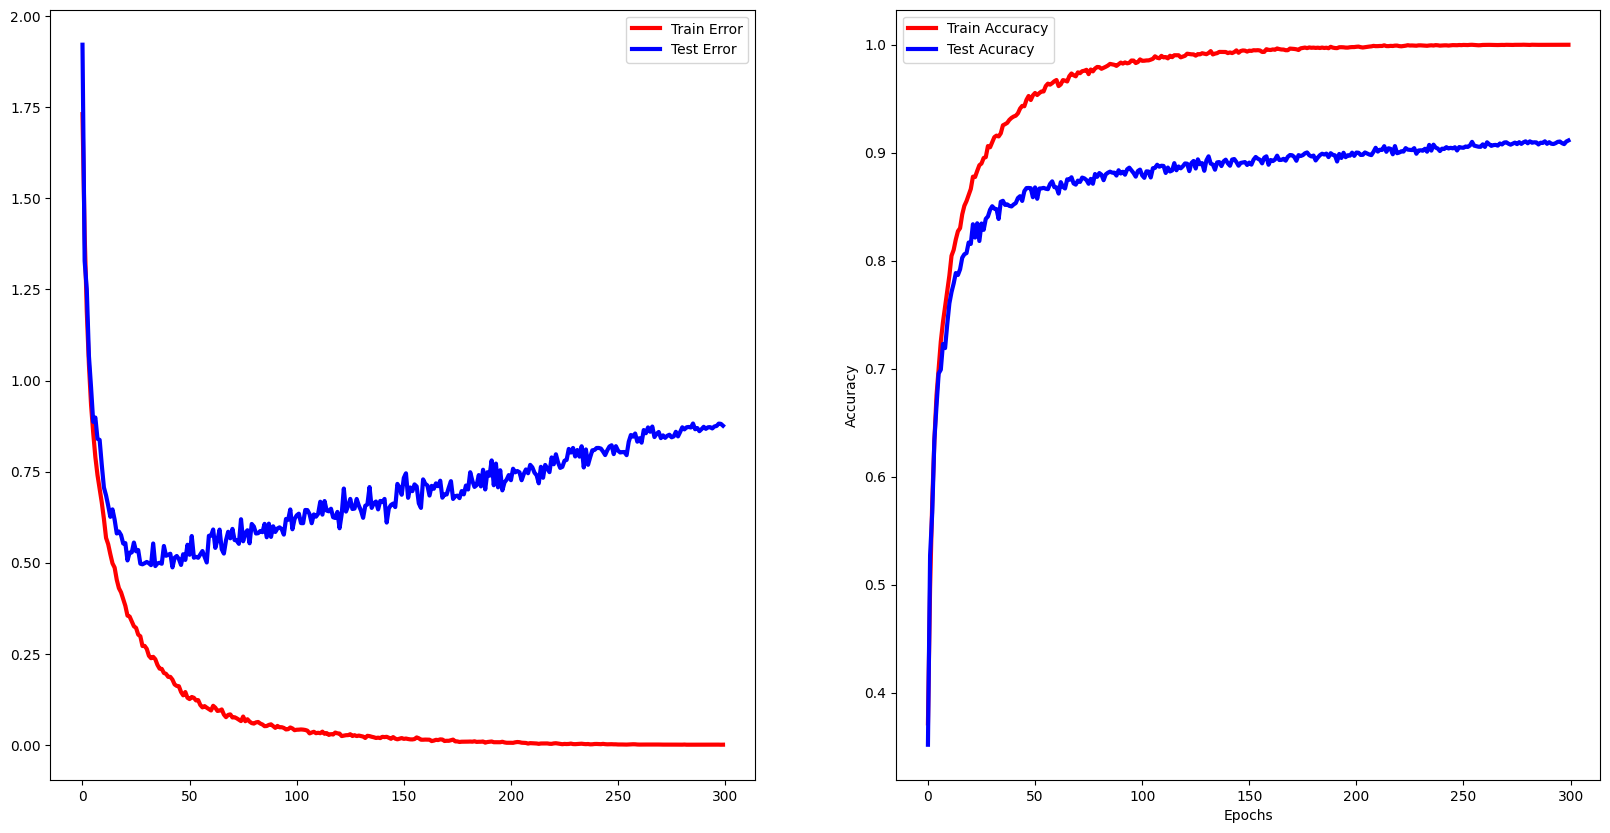

In [10]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
n = len(trainingLoss)
ax1.plot(range(n), trainingLoss, '-', linewidth='3', label='Train Error',color='Red')
ax1.plot(range(n), testingLoss, '-', linewidth='3', label='Test Error',color='Blue')

ax2.plot(range(n), trainingAccuracy, '-', linewidth='3', label='Train Accuracy',color='Red')
ax2.plot(range(n), testingAccuracy, '-', linewidth='3', label='Test Acuracy',color='Blue')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

ax1.legend()
ax2.legend()
figure.savefig("./trainTestCurve.png")

In [11]:
corrects = 0.0
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    output = torch.argmax(output, dim=1)
    corrects += torch.sum(labels == output).float().item()
print(corrects/len(test_loader.dataset))

0.9113


In [14]:
!pip install onnx
model = resnet_model()
model.load_state_dict(torch.load('./saved_model.pt'))
# set the model to evaluation mode 
model.eval() 

# Let's create a sample input tensor  
x = torch.randn(4, 3, 32, 32)

torch.onnx.export(model, x, "final_resnet_model.onnx", opset_version = 11)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 89.2 MB/s eta 0:00:00


Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4
============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

